The algorithm works like this:

![](https://mermaid.ink/svg/pako:eNqFVulu2zAMfhXCv1K03QPkx4b0WFFg64K2G7DZRaHYTCzElgxZTtfr3UcdPuQ4nYDWEimSH0_lNUplhtE82ihW5XB_kQigVTcrR_i5WMKi2EjFdV46nll3mik9m9nP0VFPvxZcc1bwF_wV93soeK1BrqFCpRu1YppLUcPuoRfsDF6hQMU0AodG8B2qmhWhXC9kLWp7PfZf0LmSzSaHusKUrzlmIJpyhYr0EYAMa66INq0aeMk2GAILvRo6FUhqFLVUsHvkwGpgXhU8UdjgBZXEeqSzc_iykmk-csqsr1JdsjSP6QtIGxCTWDnZzsltxbjgYgMZ06xG_bCvsLM4DpXTtC9g1hXqa8OOaWMNCfyrvXPG9P_NjsriHstqGEWnymcrDV3cPWq6_UEQ23WeY7qN7X_gayippAvgNaylLCjbq2cLPdQNx17_AZ1duH5Umpf8xYktlVwVWE6LmLWk8uKpjpPoO9uih1I5olFgnaF22nBB1cdE1sIinC4WM_c5tsXUgjxKoofDRs8Usm18i1qZgtdSUq1TRX75QOSbrOv4nBVpU7haoC4lksNnToMGkqq0SLkwTYNwdn75ERiWbislK7YxfRmcQIrekpawoaJK6UDtSSfDychobeK0ko3ImHr-wJDN94UXOPP3-yqYVAdP1J7K9BNmB1SjyKYZiyyL6Y_Qp-PB4SuVnDgwWSiXB8zdYoVM97BZUYBvrLbHc7ZDWCESwbVu1vbuhM5J-F2iByk3zWFa186C0XB2g4xSnraw2skZSPFDsdwDcUcuxIuqwr7ge0MUNvtCjOeujcnNcjj8-zi1gFhJqbWvy4H3giZ_Tkm38dtHGyDtd9RLjRKzmfvCrn3k7HW3tY8fnJ5-Ho43xxoQ3AWXNs_04zeUHAtatn8DHM8fLKMdy47TnsZgzKzdA2SI9qKNpGO7oBLx7TfWb6bQx_Qb-daONsfyB6vJzBJHNTtLCtre8cJJ0CEYN_DA8phlhaYgTl80mO1k9PbNtucE3njep06_60rHND1vxIY0t-9D1rXVmO2Mhfnqe7B3yDTIJNeIB3VgbvbhC9tjEJOQ0SUxKMVDF30ITOknIjqJSlQl4xn9THw1gklEs7XEJJrTluK9TaJEvNM91mh59yzSaK5VgydRU9HvArzgjF7SMpqvWVETtWLij5Tt-f0f7X5Wpw)

In [1]:
# %load_ext autoreload
# %autoreload 2

import os

os.chdir("..")

import torch
import wandb
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.utils.download import download_models
from src.utils.uap_helper import generate_adversarial_images_from_model_dataset, get_datamodule
from src.utils.metrics import metrics, Metrics
from src.data.mri import MRIDataModule
from src.data.covidx import COVIDXDataModule
from src.utils.evaluation import WeightsandBiasEval
from src.models.imageclassifier import ImageClassifier
from lightning.pytorch import loggers as pl_loggers

In [2]:
ENTITY = "24FS_I4DS27"
PROJECT = "baselines"
NUM_WORKERS = 8

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224), antialias=True),
    ]
)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
# Download models if not present
models = download_models(ENTITY, PROJECT)

In [6]:
modelname, dataset = "densenet121", "covidx_data"
print(f"\n---\nModel: {modelname} - Dataset: {dataset}")

current_robustification = 0

logger = pl_loggers.CSVLogger("robustified_models", name=f"{modelname}-{dataset}-robustification_{current_robustification}", version="UAPs_pre_robustification", flush_logs_every_n_steps=1)
perturbations = generate_adversarial_images_from_model_dataset(
    modelname,
    dataset,
    logger=logger,
    transform=transform,
    i=2,
    n=50,
    r=0.5,
    p=2,
    lambda_norm=0.002,
    t=20,
    eps=1e-6,
    seed=42,
    num_workers=NUM_WORKERS,
    device=device,
    verbose=False,
)
logger.save()


---
Model: densenet121 - Dataset: covidx_data


/home/gabrieltorresgamez/.local/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory robustified_models/densenet121-covidx_data-robustification_0/UAPs_pre_robustification exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!


Universal Pertubation:   0%|          | 0/2 [00:00<?, ?it/s]

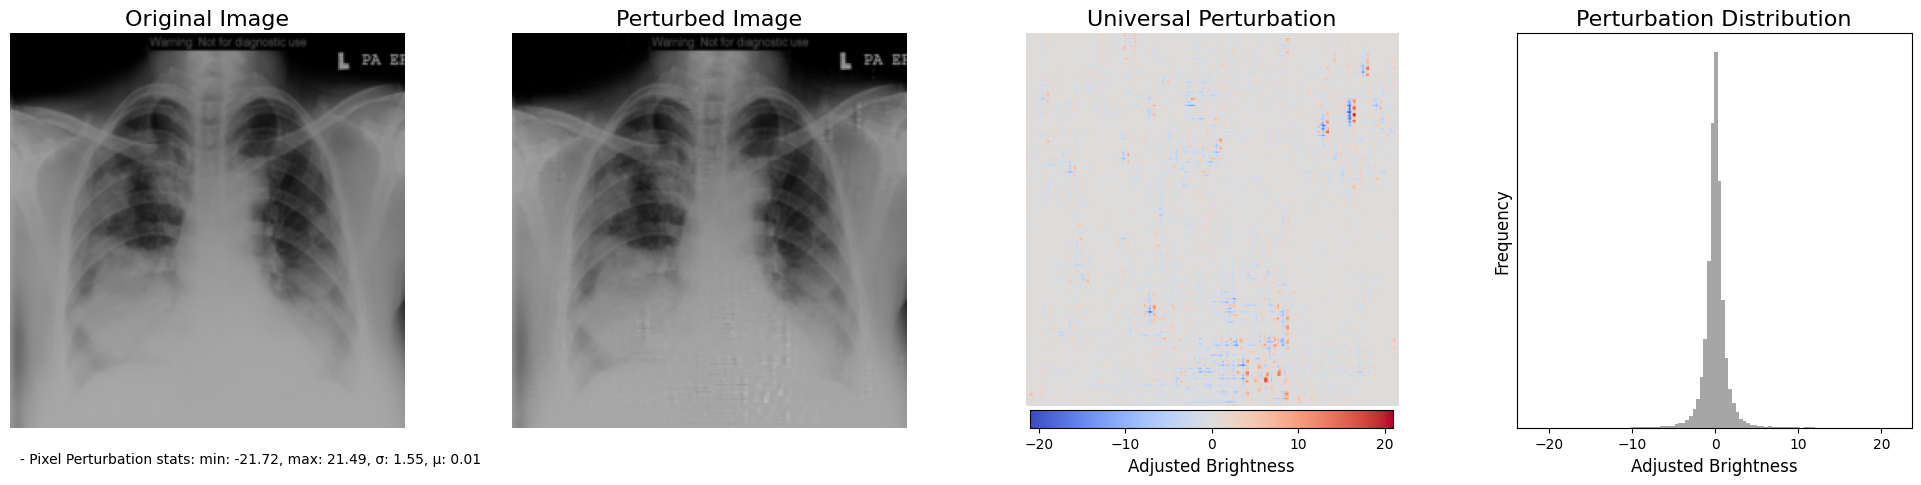

In [82]:
import matplotlib.pyplot as plt 
import torch

v = perturbations[0].detach()
get_datamodule(dataset, seed=42).setup()
image, _ = next(iter(get_datamodule(dataset).train_dataloader()))

# Prepare subplots in one row
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Original Image
axs[0].imshow(image.cpu().squeeze().permute(1, 2, 0).numpy().astype(int))
axs[0].set_title("Original Image", fontsize=16)
axs[0].axis("off")  # Hide axes for cleaner look

# Perturbed Image
x_adv = image + v.cpu()
x_adv = torch.clamp(x_adv, 0, 255)
axs[1].imshow(x_adv.cpu().squeeze().permute(1, 2, 0).numpy().astype(int))
axs[1].set_title("Perturbed Image", fontsize=16)
axs[1].axis("off")

# Perturbation Visualization
perturbation_visual = v.mean(dim=0).cpu().squeeze().numpy().astype(int)
vmax = abs(perturbation_visual).max()
im = axs[2].imshow(perturbation_visual, cmap="coolwarm", vmin=-vmax, vmax=vmax)
axs[2].set_title("Universal Perturbation", fontsize=16)
axs[2].axis("off")
cbar = plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.01, location="bottom")
cbar.set_label("Adjusted Brightness", fontsize=12)

# Statistical Distribution of Perturbation
axs[3].hist(v.cpu().flatten(), bins=100, color="grey", alpha=0.7)
axs[3].set_aspect(0.0013125, adjustable="box")
axs[3].set_title("Perturbation Distribution", fontsize=16)
axs[3].set_yticks([])
axs[3].axis("on")
axs[3].set_ylabel("Frequency", fontsize=12)
axs[3].set_xlabel("Adjusted Brightness", fontsize=12)

plt.suptitle(
    f"- Pixel Perturbation stats: min: {v.min().item():.2f}, max: {v.max().item():.2f}, σ: {v.std().item():.2f}, μ: {v.mean().item():.2f}",
    fontsize=10,
    y=0.075,
    x=0.145,
)

plt.tight_layout()
plt.show()